In [312]:
import numpy as np
import pandas as pd

pd.set_option("display.width", 1000)

In [313]:
logs = [
    "../log-simple-cloudflare",
    "../log-single-cloudflare",
    "../log-simple-client1",
    "../log-single-client1",
]


In [314]:
names = {
    "../log-simple-cloudflare-h2": "実験1 Cloudflare\nHTTP/2 /simple.html",
    "../log-simple-cloudflare-h3": "実験1 Cloudflare\nHTTP/3 /simple.html",
    "../log-single-cloudflare-h2": "実験1 Cloudflare\nHTTP/2 /single.html",
    "../log-single-cloudflare-h3": "実験1 Cloudflare\nHTTP/3 /single.html",
    "../log-simple-client1-h2": "実験1 NGINX\nHTTP/2 /simple.html",
    "../log-simple-client1-h3": "実験1 NGINX\nHTTP/3 /simple.html",
    "../log-single-client1-h2": "実験1 NGINX\nHTTP/2 /single.html",
    "../log-single-client1-h3": "実験1 NGINX\nHTTP/3 /single.html",
}


In [315]:
def analyze(
    df: pd.DataFrame, log: str, protocol: str
) -> tuple[pd.Series, pd.DataFrame]:
    df = df[
        ((df["protocol"] == "h2") | (df["protocol"] == "h3")) & (df["status"] == 200)
    ]
    # print(f"{df.size=}")

    df_groupby = df[["n", "startMili", "endMili", "baseUnixTime"]].groupby("n")

    # print(f'start = {df_groupby.min()["baseUnixTime"].min()}')
    # print(f'end = {df_groupby.max()["baseUnixTime"].max()}')

    df_groupby_count = df_groupby.count()["startMili"]
    df_success = df_groupby_count == df_groupby_count.mode()[0]
    # print(f"{df_success[df_success].size=}")

    df_mins = df_groupby.min()["startMili"]
    df_maxs = df_groupby.max()["endMili"]
    duration_df = df_maxs - df_mins
    duration_df = duration_df[df_success]

    duration_df_describe = duration_df.describe()
    duration_df_describe["filtered"] = False
    duration_df_describe["Path"] = f"{log}-{protocol}"

    df_lower_limit = duration_df_describe["mean"] - duration_df_describe["std"] * 3
    df_upper_limit = duration_df_describe["mean"] + duration_df_describe["std"] * 3

    duration_df_filtered = duration_df[
        (df_lower_limit < duration_df) & (duration_df < df_upper_limit)
    ]
    duration_df_filtered = duration_df_filtered.reset_index(drop=True)

    df_des = duration_df_filtered.describe()
    df_des["filtered"] = True
    df_des["Path"] = f"{log}-{protocol}"

    return (
        duration_df_filtered,
        pd.DataFrame(
            [duration_df_describe, df_des],
            # index=[f"{log}-{protocol}", f"{log}-{protocol}"],
        ),
    )


In [316]:
def compare(df: pd.DataFrame, descrives: pd.DataFrame, log: str):
    h2 = pd.read_json(log + "/h2-performances-processed.json")
    h3 = pd.read_json(log + "/h3-performances-prosessed.json")
    # print()
    # print(log)
    # print("h2")
    series_h2, result_h2 = analyze(h2, log, "h2")
    df[f"{log}-h2"] = series_h2
    descrives = pd.concat([descrives, result_h2])
    # print(result_h2)
    # print("h3")
    series_h3, result_h3 = analyze(h3, log, "h3")
    df[f"{log}-h3"] = series_h3
    descrives = pd.concat([descrives, result_h3])
    # print(result_h3)
    return df, descrives


In [317]:
results = pd.DataFrame()
describes = pd.DataFrame(
    columns=["count", "mean", "std", "min", "25%", "50%", "75%", "max"]
)
for log in logs:
    (results, describes) = compare(results, describes, log)
print(results.count())
results.to_csv("client-time.csv")
describes = describes.sort_values("filtered")
describes["Path"] = describes["Path"].replace(names)
describes = describes.rename(
    columns={
        "Path": "実験",
        "count": "リクエスト数",
        "mean": "平均値",
        "std": "標準偏差",
        "min": "最小値",
        "25%": "第1四分数",
        "50%": "中央値",
        "75%": "第3四分数",
        "max": "最大",
    }
)
describes = describes.reindex(
    columns=[
        "実験",
        "リクエスト数",
        "平均値",
        "標準偏差",
        "最小値",
        "第1四分数",
        "中央値",
        "第3四分数",
        "最大",
        "filtered",
    ]
)
describes.to_csv("client-time-describe.csv")

describe_unfiltered = describes[describes["filtered"] == False].drop(
    columns=["filtered"]
)
describe_unfiltered.to_csv("client-time-describe-unfiltered.csv", index=False)
describe_filtered = describes[describes["filtered"] == True].drop(columns=["filtered"])
describe_filtered.to_csv("client-time-describe-filtered.csv", index=False)


/var/folders/bf/kn4k8swd7vq0tzxz1_jvzsr80000gq/T/ipykernel_94867/2709141471.py:14: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  descrives = pd.concat([descrives, result_h3])
/var/folders/bf/kn4k8swd7vq0tzxz1_jvzsr80000gq/T/ipykernel_94867/2709141471.py:9: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  descrives = pd.concat([descrives, result_h2])
/var/folders/bf/kn4k8swd7vq0tzxz1_jvzsr80000gq/T/ipykernel_94867/2709141471.py:14: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  descrives = pd.concat([descrives, result_h3])
/var/folders/bf/kn4k8swd7vq0tzxz1_jvzsr80000gq/T/ipykernel_94867/2709141471.py:9: FutureW

../log-simple-cloudflare-h2    976
../log-simple-cloudflare-h3    976
../log-single-cloudflare-h2    976
../log-single-cloudflare-h3    974
../log-simple-client1-h2       976
../log-simple-client1-h3       976
../log-single-client1-h2       877
../log-single-client1-h3       954
dtype: int64


/var/folders/bf/kn4k8swd7vq0tzxz1_jvzsr80000gq/T/ipykernel_94867/2709141471.py:9: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  descrives = pd.concat([descrives, result_h2])
/var/folders/bf/kn4k8swd7vq0tzxz1_jvzsr80000gq/T/ipykernel_94867/2709141471.py:14: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  descrives = pd.concat([descrives, result_h3])


In [318]:
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager

# print([f.name for f in matplotlib.font_manager.fontManager.ttflist])
font = {"family": "YuGothic"}
matplotlib.rc("font", **font)


In [319]:
describe_unfiltered

,実験,リクエスト数,平均値,標準偏差,最小値,第1四分数,中央値,第3四分数,最大
0,実験1 Cloudflare\nHTTP/2 /simple.html,1000.0,109.227000,15.950043,84.0,99.0,105.0,115.0,217.0
0,実験1 Cloudflare\nHTTP/3 /simple.html,1000.0,87.078000,12.262475,66.0,80.0,84.0,90.0,198.0
0,実験1 Cloudflare\nHTTP/2 /single.html,998.0,1443.545090,30.278041,1399.0,1426.0,1436.0,1451.0,1758.0
0,実験1 Cloudflare\nHTTP/3 /single.html,984.0,1467.864837,147.703130,1387.0,1422.0,1440.0,1474.0,4831.0
0,実験1 NGINX\nHTTP/2 /simple.html,1000.0,40.646000,2.494977,32.0,40.0,41.0,42.0,53.0
0,実験1 NGINX\nHTTP/3 /simple.html,1000.0,41.924000,2.590547,33.0,41.0,43.0,44.0,47.0
0,実験1 NGINX\nHTTP/2 /single.html,883.0,1516.597961,25.317984,1444.0,1500.0,1516.0,1531.0,1712.0
0,実験1 NGINX\nHTTP/3 /single.html,962.0,1447.912682,5.515343,1429.0,1445.0,1449.0,1452.0,1461.0


In [320]:
describe_filtered

,実験,リクエスト数,平均値,標準偏差,最小値,第1四分数,中央値,第3四分数,最大
1,実験1 Cloudflare\nHTTP/2 /simple.html,976.0,107.622951,12.134598,84.0,99.0,104.0,114.00,157.0
1,実験1 Cloudflare\nHTTP/3 /simple.html,984.0,86.227642,10.135953,66.0,80.0,84.0,90.00,123.0
1,実験1 Cloudflare\nHTTP/2 /single.html,976.0,1440.561475,21.674854,1399.0,1426.0,1436.0,1450.00,1534.0
1,実験1 Cloudflare\nHTTP/3 /single.html,974.0,1456.475359,50.898998,1387.0,1422.0,1440.0,1470.75,1811.0
1,実験1 NGINX\nHTTP/2 /simple.html,990.0,40.687879,2.360476,34.0,40.0,41.0,42.00,45.0
1,実験1 NGINX\nHTTP/3 /simple.html,991.0,41.997982,2.482259,35.0,41.0,43.0,44.00,47.0
1,実験1 NGINX\nHTTP/2 /single.html,877.0,1515.728620,22.875068,1444.0,1500.0,1516.0,1531.00,1590.0
1,実験1 NGINX\nHTTP/3 /single.html,954.0,1448.060797,5.294127,1432.0,1445.0,1449.0,1452.00,1461.0


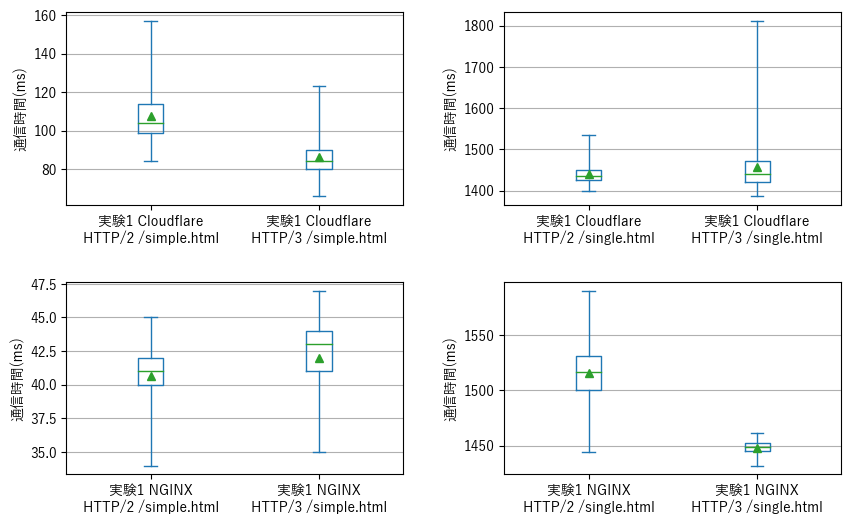

In [321]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

ploted = results[["../log-simple-cloudflare-h2", "../log-simple-cloudflare-h3"]].copy()
ploted.columns = [
    "実験1 Cloudflare\nHTTP/2 /simple.html",
    "実験1 Cloudflare\nHTTP/3 /simple.html",
]
ploted = ploted.plot.box(
    ax=axes[0, 0], showmeans=True, ylabel="通信時間(ms)", whis=[0, 100]
)
ploted.grid(which="major", axis="y")

ploted = results[["../log-single-cloudflare-h2", "../log-single-cloudflare-h3"]].copy()
ploted.columns = [
    "実験1 Cloudflare\nHTTP/2 /single.html",
    "実験1 Cloudflare\nHTTP/3 /single.html",
]
ploted = ploted.plot.box(
    ax=axes[0, 1], showmeans=True, ylabel="通信時間(ms)", whis=[0, 100]
)
ploted.grid(which="major", axis="y")

ploted = results[["../log-simple-client1-h2", "../log-simple-client1-h3"]].copy()
ploted.columns = [
    "実験1 NGINX\nHTTP/2 /simple.html",
    "実験1 NGINX\nHTTP/3 /simple.html",
]
ploted = ploted.plot.box(
    ax=axes[1, 0], showmeans=True, ylabel="通信時間(ms)", whis=[0, 100]
)
ploted.grid(which="major", axis="y")

ploted = results[["../log-single-client1-h2", "../log-single-client1-h3"]].copy()
ploted.columns = [
    "実験1 NGINX\nHTTP/2 /single.html",
    "実験1 NGINX\nHTTP/3 /single.html",
]
ploted = ploted.plot.box(
    ax=axes[1, 1], showmeans=True, ylabel="通信時間(ms)", whis=[0, 100]
)
ploted.grid(which="major", axis="y")
